### Import libraries

In [81]:
# Import standard libraries
import os, datetime
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl
import igraph
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import hvplot.pandas
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')
%matplotlib inline

import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import seaborn as sb
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
# import cairo
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import zscore
from scipy.sparse.linalg import norm
import networkx as nx
from pyvis.network import Network

## Load environment variables from .env file and find project root
import sys
from dotenv import load_dotenv, find_dotenv
load_dotenv()
PROJECT_ROOT = Path(find_dotenv()).parent
# data_path = Path(PROJECT_ROOT, 'results', 'eyemap')
store_path = Path(PROJECT_ROOT, 'results','AOTU_Connectivity')
sys.path.append(str(PROJECT_ROOT.joinpath('src')))


from utils import olc_client
c = olc_client.connect(verbose=True)

from utils.celltype_conn_by_roi import CelltypeConnByRoi
from utils.celltype_conn_plotter import CelltypeConnPlotter
from utils.plotter import plot_cns, save_figure, get_skeletons, get_skeleton, get_meshes, get_mesh, show_figure
from utils.helper import slugify
from utils.neuron_bag import NeuronBag

# Import neuPrint specific libraries
from neuprint import Client, fetch_neurons, NeuronCriteria as NC, fetch_neurons, fetch_simple_connections, fetch_adjacencies, connection_table_to_matrix, merge_neuron_properties, NotNull, fetch_synapse_connections, fetch_neurons,fetch_primary_rois, fetch_all_rois, fetch_synapses, fetch_roi_hierarchy
from neuprint.utils import connection_table_to_matrix

Loading BokehJS ...

Connected to https://neuprint-cns.janelia.org[cns].
Client: neuprint-python v1.7.4
User: aishahamid201@gmail.com [readwrite]



### list of things want to try

- get the list of AOTU cell types in the male CNS dataset

In [82]:
# Fetch AOTU neurons and get their types
neurons_df,roi_df = fetch_neurons(NC(type='^AOTU.*'))
neurons_df

,bodyId,instance,type,pre,post,downstream,upstream,size,status,statusLabel,...,celltypePredictedNt,receptorType,consensusNt,mancBodyid,tosomaLocation,mancType,assignedOlHex1,matchingNotes,inputRois,outputRois
0,10005,AOTU019_R,AOTU019,2837,31981,23423,31981,11847745920,Traced,Roughly traced,...,gaba,None,gaba,None,None,None,None,None,"[AOTU(R), CRE(R), CentralBrain, CentralBrain-u...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."
1,10031,AOTU041_R,AOTU041,2134,20586,13446,20586,5326291658,Traced,Roughly traced,...,gaba,None,gaba,None,None,None,None,None,"[AOTU(L), AOTU(R), CRE(L), CRE(R), CentralBrai...","[AOTU(L), AOTU(R), CentralBrain, CentralBrain-..."
2,10070,AOTU019_L,AOTU019,2836,30714,23596,30714,11809707230,Traced,Roughly traced,...,gaba,None,gaba,None,None,None,None,None,"[AOTU(L), CRE(L), CentralBrain, CentralBrain-u...","[AOTU(L), CRE(L), CentralBrain, CentralBrain-u..."
3,10148,AOTU041_L,AOTU041,2336,19960,14187,19960,5592462575,Traced,Roughly traced,...,gaba,None,gaba,None,None,None,None,None,"[AOTU(L), AOTU(R), BU(L), CRE(L), CentralBrain...","[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr..."
4,10212,AOTU042_L,AOTU042,3579,10679,22690,10679,4312493196,Traced,Roughly traced,...,gaba,None,gaba,None,None,None,None,None,"[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr...","[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,555803,AOTU024_R,AOTU024,814,2240,6989,2240,964400165,Traced,Roughly traced,...,acetylcholine,None,acetylcholine,None,None,None,None,None,"[AOTU(R), ATL(L), ATL(R), CRE(R), CentralBrain...","[AOTU(R), ATL(L), ATL(R), CentralBrain, Centra..."
310,557095,AOTU008_L,AOTU008,392,2167,3198,2167,832073642,Traced,Roughly traced,...,acetylcholine,None,acetylcholine,None,None,None,None,ventrally projecting axonal arbors mcns,"[AOTU(L), AOTU(R), CentralBrain, CentralBrain-...","[AOTU(L), CentralBrain, CentralBrain-unspecifi..."
311,565505,AOTU008_R,AOTU008,315,2727,2802,2727,502528277,Traced,Roughly traced,...,acetylcholine,None,acetylcholine,None,None,None,None,ventrally projecting axonal arbors mcns,"[AOTU(R), CentralBrain, CentralBrain-unspecifi...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."
312,902249,AOTU038_R,AOTU038,111,459,704,459,278656951,Traced,Roughly traced,...,dopamine,None,dopamine,None,None,None,None,None,"[AOTU(R), AVLP(R), CentralBrain, CentralBrain-...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."


In [83]:
AOTU_celltypes = neurons_df['type'].unique()
AOTU_celltypes

array(['AOTU019', 'AOTU041', 'AOTU042', 'AOTU023', 'AOTU012', 'AOTU035',
       'AOTU005', 'AOTU100m', 'AOTU016_c', 'AOTU061', 'AOTU052',
       'AOTU103m', 'AOTU063_b', 'AOTU064', 'AOTU033', 'AOTU101m',
       'AOTU063_a', 'AOTU049', 'AOTU027', 'AOTU014', 'AOTU015', 'AOTU046',
       'AOTU050', 'AOTU024', 'AOTU059', 'AOTU009', 'AOTU008', 'AOTU045',
       'AOTU065', 'AOTU007_c', 'AOTU002_c', 'AOTU029', 'AOTU016_a',
       'AOTU002_a', 'AOTU026', 'AOTU020', 'AOTU017', 'AOTU028',
       'AOTU016_b', 'AOTU036', 'AOTU006', 'AOTU043', 'AOTU048', 'AOTU013',
       'AOTU051', 'AOTU034', 'AOTU011', 'AOTU002_b', 'AOTU022', 'AOTU062',
       'AOTU032', 'AOTU001', 'AOTU007_b', 'AOTU047', 'AOTU003',
       'AOTU007_a', 'AOTU054', 'AOTU030', 'AOTU056', 'AOTU055', 'AOTU060',
       'AOTU102m', 'AOTU038', 'AOTU058', 'AOTU053', 'AOTU037', 'AOTU018',
       'AOTU004', 'AOTU039', 'AOTU040', 'AOTU021', 'AOTU025'],
      dtype=object)

In [84]:
######### Only males
# Filter types that end with lowercase 'm'
aotu_types_ending_with_m = [t for t in AOTU_celltypes if isinstance(t, str) and t.endswith('m')]

# Optional: sort them alphabetically
aotu_types_ending_with_m.sort()

# Print the result
print("AOTU types ending with 'm':")
print(aotu_types_ending_with_m)


AOTU types ending with 'm':
['AOTU100m', 'AOTU101m', 'AOTU102m', 'AOTU103m']


- get the AOTU connectivity matrix

In [100]:
#  Define pre- and post-synaptic cell types
celltypes_pre = AOTU_celltypes
celltypes_post = AOTU_celltypes
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_AOTU_df = merge_neuron_properties(neu_df, conn_df)

conn_AOTU_df


  0%|          | 0/2 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10005,10070,LAL(L),18,AOTU019,AOTU019_R,AOTU019,AOTU019_L
1,10005,10070,SPS(L),8,AOTU019,AOTU019_R,AOTU019,AOTU019_L
2,10005,10070,VES(L),7,AOTU019,AOTU019_R,AOTU019,AOTU019_L
3,10005,10070,EPA(L),5,AOTU019,AOTU019_R,AOTU019,AOTU019_L
4,10005,10410,SIP(R),3,AOTU019,AOTU019_R,AOTU035,AOTU035_R
...,...,...,...,...,...,...,...,...
6673,902249,75501,LAL(L),17,AOTU038,AOTU038_R,AOTU037,AOTU037_L
6674,902249,119700,LAL(L),6,AOTU038,AOTU038_R,AOTU037,AOTU037_L
6675,902249,122986,LAL(L),9,AOTU038,AOTU038_R,AOTU037,AOTU037_L
6676,902249,123833,SPS(L),4,AOTU038,AOTU038_R,AOTU040,AOTU040_R


In [101]:
# Group by type combinations and sum the weights
conn_AOTU_df_type = conn_AOTU_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

conn_AOTU_df_type

,type_pre,type_post,weight
0,AOTU001,AOTU001,18
1,AOTU001,AOTU004,3
2,AOTU001,AOTU019,9
3,AOTU001,AOTU033,6
4,AOTU001,AOTU038,3
...,...,...,...
1123,AOTU103m,AOTU056,5
1124,AOTU103m,AOTU058,7
1125,AOTU103m,AOTU101m,4
1126,AOTU103m,AOTU102m,31



- normalize
- look at subsets of this matrix

In [102]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_AOTU_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)

In [103]:

conn_AOTU_df_type_sort = conn_AOTU_df_type.sort_values(by='weight', ascending=False)

In [104]:
#filter for only strong connections
conn_AOTU_df_type_top = conn_AOTU_df_type_sort[conn_AOTU_df_type_sort['weight']>300]

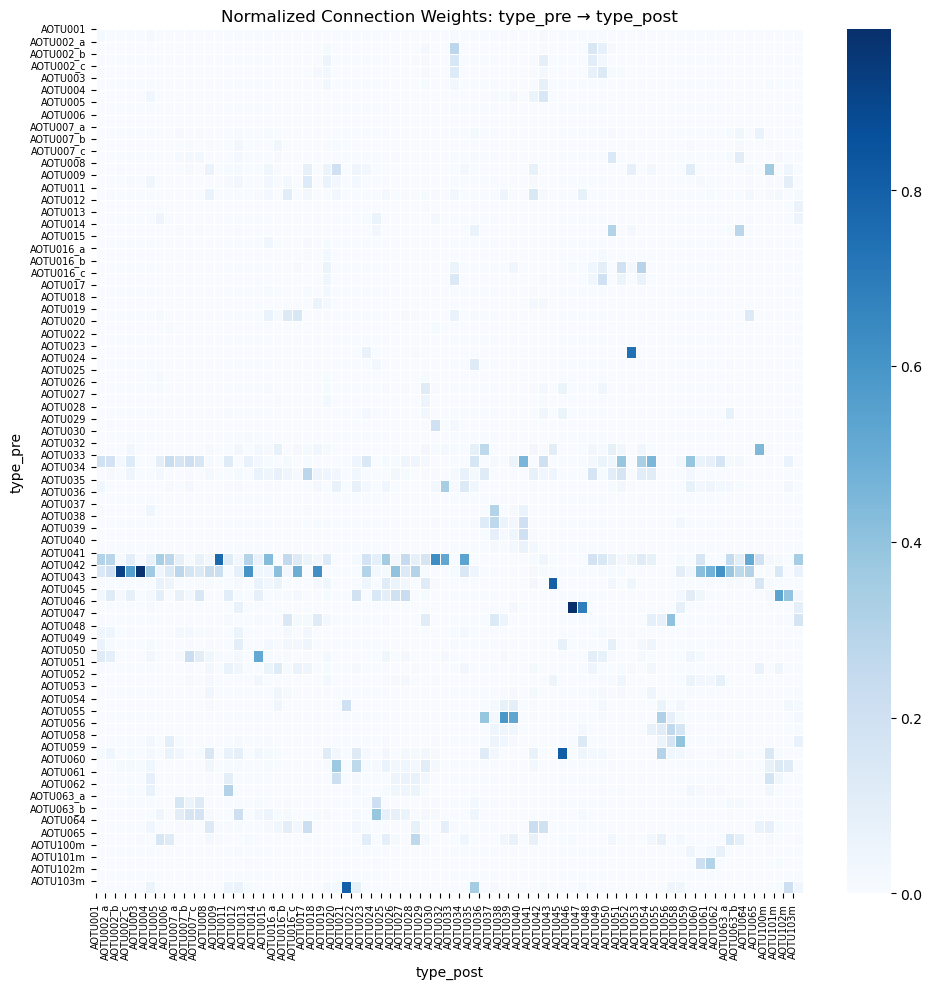

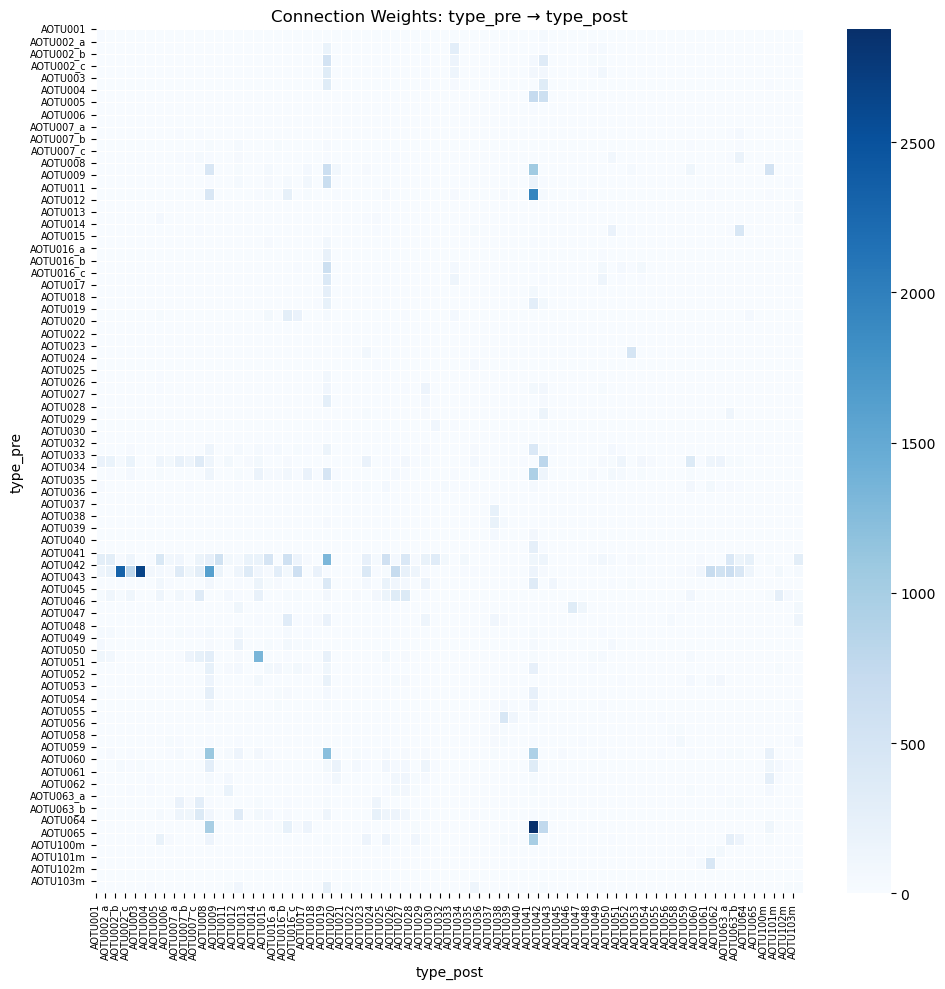

In [105]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 10))
ax = sb.heatmap(norm_matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Normalized Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()


# weights without normalization
# Create the heatmap
plt.figure(figsize=(10, 10))
ax = sb.heatmap(matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(matrix_df.index)))
ax.set_yticklabels(matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(matrix_df.columns)))
ax.set_xticklabels(matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()


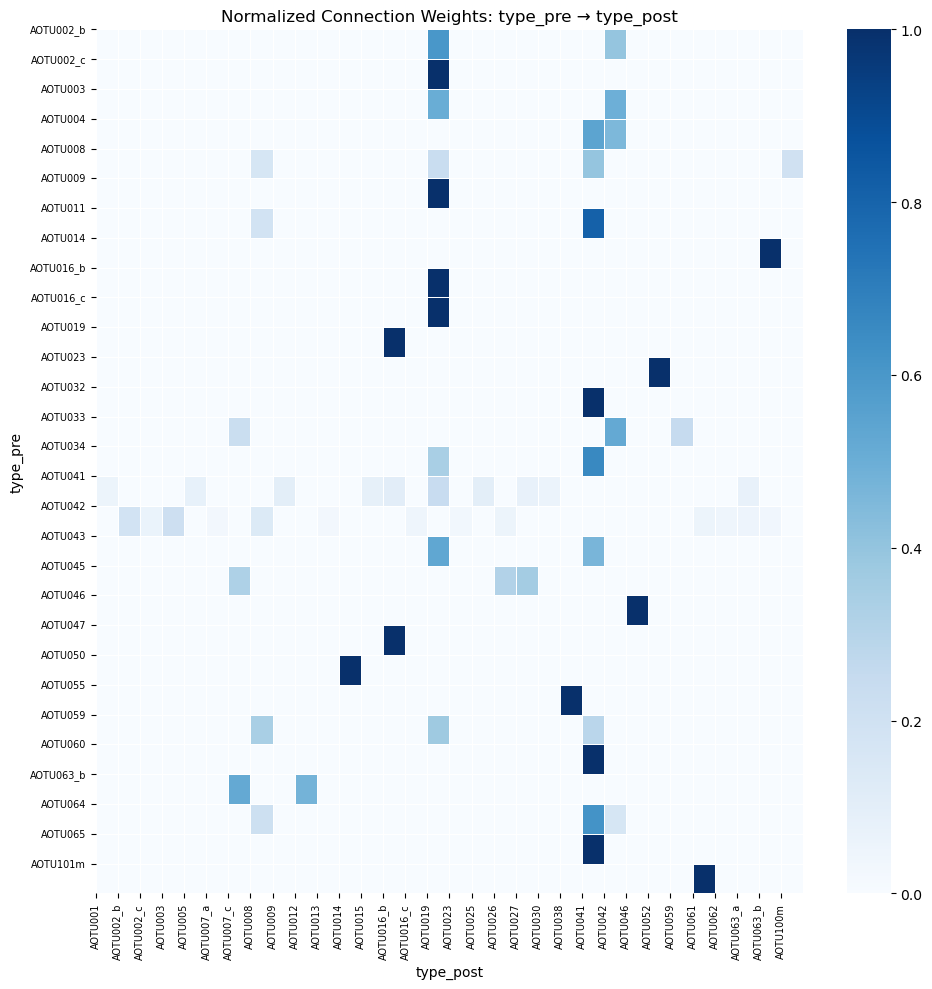

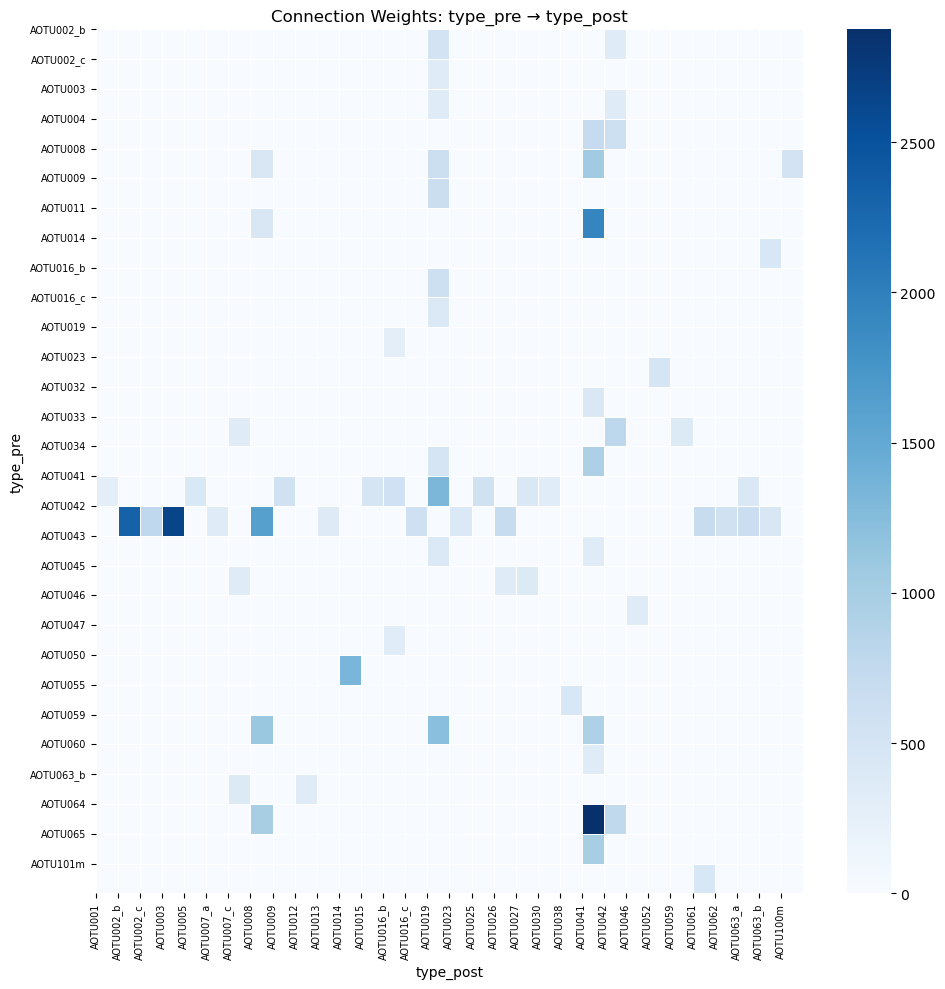

In [ ]:
A


- get the top upstream and downstream partners of AOTU041 (example)
- (within AOTU types and all other neurons)

/var/folders/nz/36wz0cz90t34jt3ryz6_n08w0000gp/T/ipykernel_4301/3477787880.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=top20_types, y='type_pre', x='weight', palette='Reds_r')


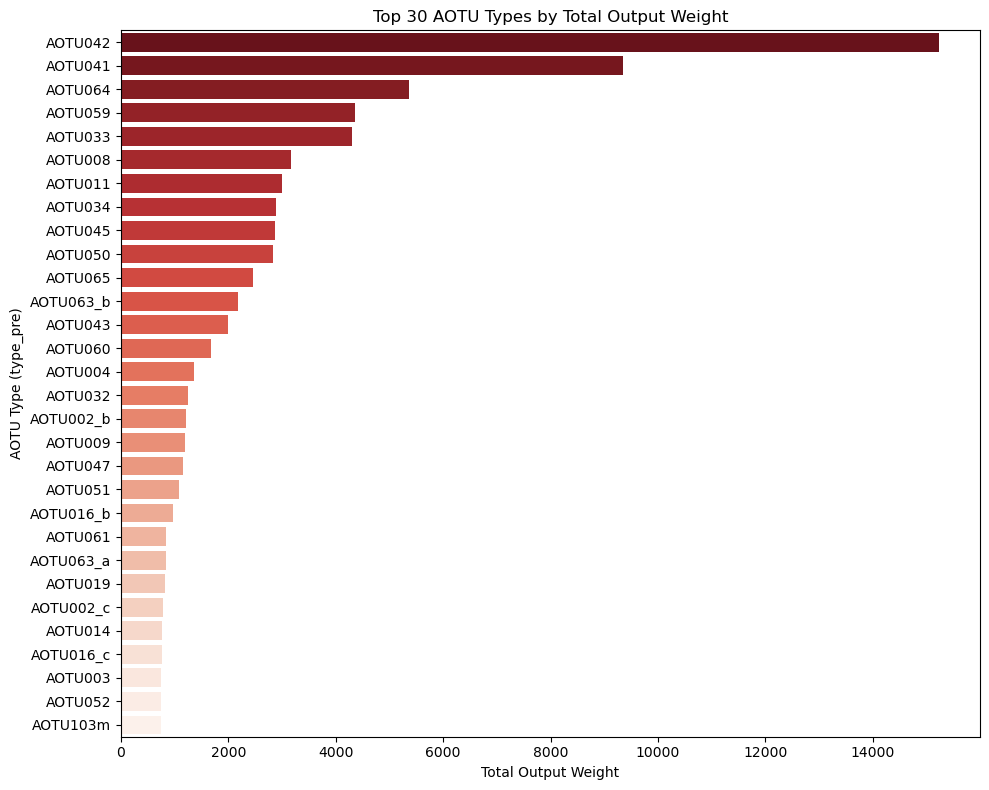

In [58]:
# Plot top connections (intra-AOTU types)

# Sum total output weight per type_pre
type_weight = conn_AOTU_df_type.groupby('type_pre')['weight'].sum().reset_index()

# Sort and select top 20
top20_types = type_weight.sort_values(by='weight', ascending=False).head(30)

plt.figure(figsize=(10,8))
sb.barplot(data=top20_types, y='type_pre', x='weight', palette='Reds_r')

# Labeling
plt.title('Top 30 AOTU Types by Total Output Weight')
plt.xlabel('Total Output Weight')
plt.ylabel('AOTU Type (type_pre)')

plt.tight_layout()
plt.show()

### AOTU41 plots, connections

In [59]:
# Filter intra-AOTU connections from earlier data
conn_AOTU_df_type = conn_AOTU_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()


# Top inputs to AOTU41 (where AOTU41 is the post type)
inputs_to_AOTU041 = conn_AOTU_df_type[conn_AOTU_df_type['type_post'] == 'AOTU041']
top_inputs_to_AOTU041 = inputs_to_AOTU041.sort_values(by='weight', ascending=False).head(15)

# Top outputs from AOTU41 (where AOTU41 is the pre type)
outputs_from_AOTU041 = conn_AOTU_df_type[conn_AOTU_df_type['type_pre'] == 'AOTU041']
top_outputs_from_AOTU041 = outputs_from_AOTU041.sort_values(by='weight', ascending=False).head(15)

In [60]:
print(top_inputs_to_AOTU041)
print(top_outputs_from_AOTU041)

     type_pre type_post  weight
1060  AOTU064   AOTU041    2875
168   AOTU011   AOTU041    1932
116   AOTU008   AOTU041    1046
1085  AOTU065   AOTU041     999
422   AOTU034   AOTU041     952
912   AOTU059   AOTU041     933
55    AOTU004   AOTU041     729
339   AOTU032   AOTU041     423
626   AOTU043   AOTU041     356
950   AOTU060   AOTU041     338
245   AOTU018   AOTU041     286
505   AOTU040   AOTU041     268
785   AOTU051   AOTU041     247
820   AOTU053   AOTU041     245
139   AOTU009   AOTU041     178
    type_pre  type_post  weight
529  AOTU041    AOTU019    1321
525  AOTU041  AOTU016_b     593
533  AOTU041    AOTU025     575
519  AOTU041    AOTU009     567
524  AOTU041    AOTU015     489
513  AOTU041    AOTU005     433
554  AOTU041  AOTU063_a     423
535  AOTU041    AOTU027     419
538  AOTU041    AOTU030     334
507  AOTU041    AOTU001     303
508  AOTU041  AOTU002_a     298
560  AOTU041   AOTU103m     293
531  AOTU041    AOTU023     243
518  AOTU041    AOTU008     239
556  AOT

/var/folders/nz/36wz0cz90t34jt3ryz6_n08w0000gp/T/ipykernel_4301/893829456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=top_inputs_to_AOTU041, x='weight', y='type_pre', palette='Blues_r')


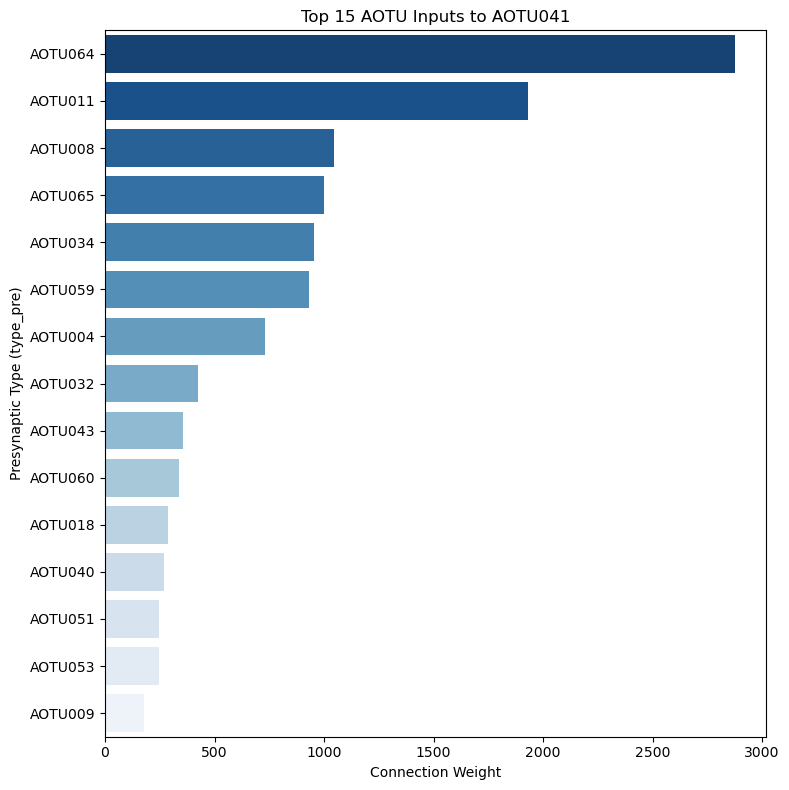

In [61]:
plt.figure(figsize=(8, 8))
sb.barplot(data=top_inputs_to_AOTU041, x='weight', y='type_pre', palette='Blues_r')
plt.title('Top 15 AOTU Inputs to AOTU041')
plt.xlabel('Connection Weight')
plt.ylabel('Presynaptic Type (type_pre)')
plt.tight_layout()
plt.show()

/var/folders/nz/36wz0cz90t34jt3ryz6_n08w0000gp/T/ipykernel_4301/3110477854.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=top_outputs_from_AOTU041, x='weight', y='type_post', palette='Greens_r')


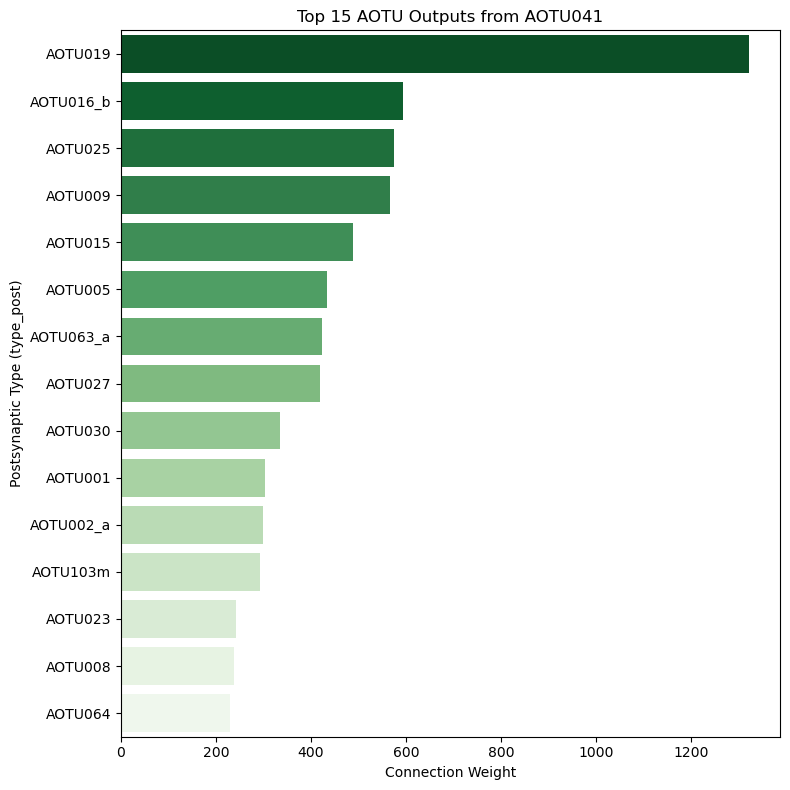

In [62]:
plt.figure(figsize=(8, 8))
sb.barplot(data=top_outputs_from_AOTU041, x='weight', y='type_post', palette='Greens_r')
plt.title('Top 15 AOTU Outputs from AOTU041')
plt.xlabel('Connection Weight')
plt.ylabel('Postsynaptic Type (type_post)')
plt.tight_layout()
plt.show()

### Graphs

In [63]:
# Calculate total connection weight for each type (pre + post)
type_out = conn_AOTU_df_type.groupby('type_pre')['weight'].sum()
type_in = conn_AOTU_df_type.groupby('type_post')['weight'].sum()

# Combine and rank
type_total = (type_out + type_in).sort_values(ascending=False)
top15_types = type_total.head(15).index.tolist()


In [64]:
# Filter to top 15 → top 15 submatrix
matrix_top15 = matrix_df.loc[top15_types, top15_types]


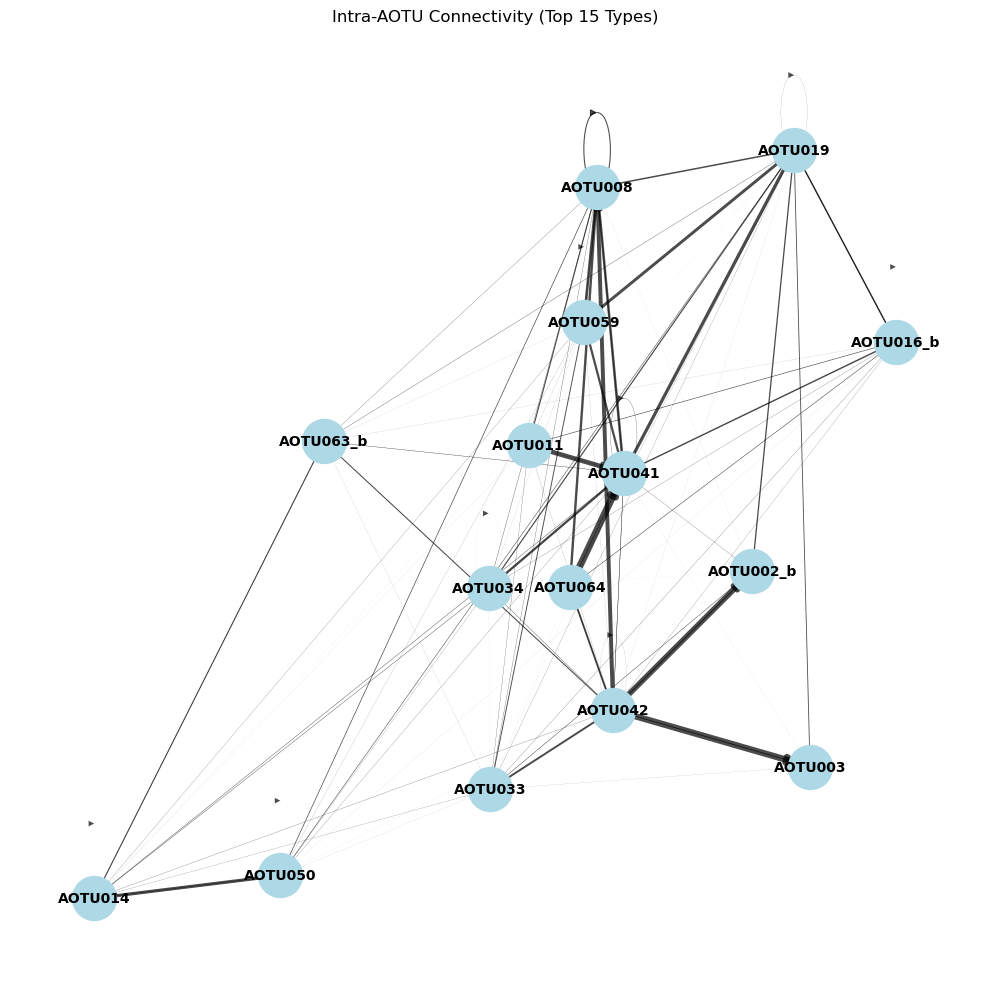

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add edges with weights from top-15 matrix
for pre in matrix_top15.index:
    for post in matrix_top15.columns:
        weight = matrix_top15.loc[pre, post]
        if weight > 0:
            G.add_edge(pre, post, weight=weight)

# Draw graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # layout for visualization

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

# Draw edges with weight-scaled width
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w / max(edge_weights) * 5 for w in edge_weights], alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Intra-AOTU Connectivity (Top 15 Types)")
plt.axis('off')
plt.tight_layout()
plt.show()


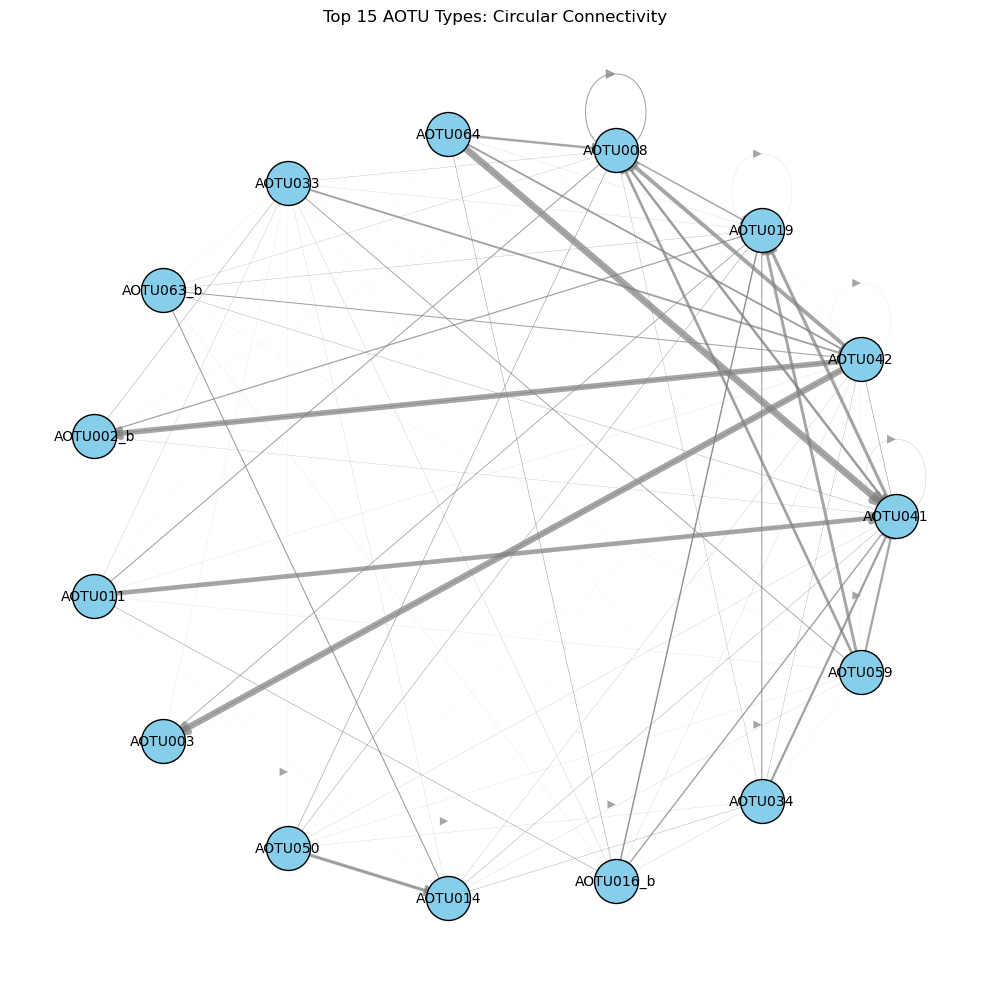

In [66]:
plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', edgecolors='k')
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge widths scaled for visibility
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_w = max(edge_weights)
scaled_weights = [w / max_w * 5 for w in edge_weights]

nx.draw_networkx_edges(G, pos, width=scaled_weights, arrowstyle='-|>', arrowsize=15, edge_color='gray', alpha=0.7)

plt.title("Top 15 AOTU Types: Circular Connectivity")
plt.axis('off')
plt.tight_layout()
plt.show()


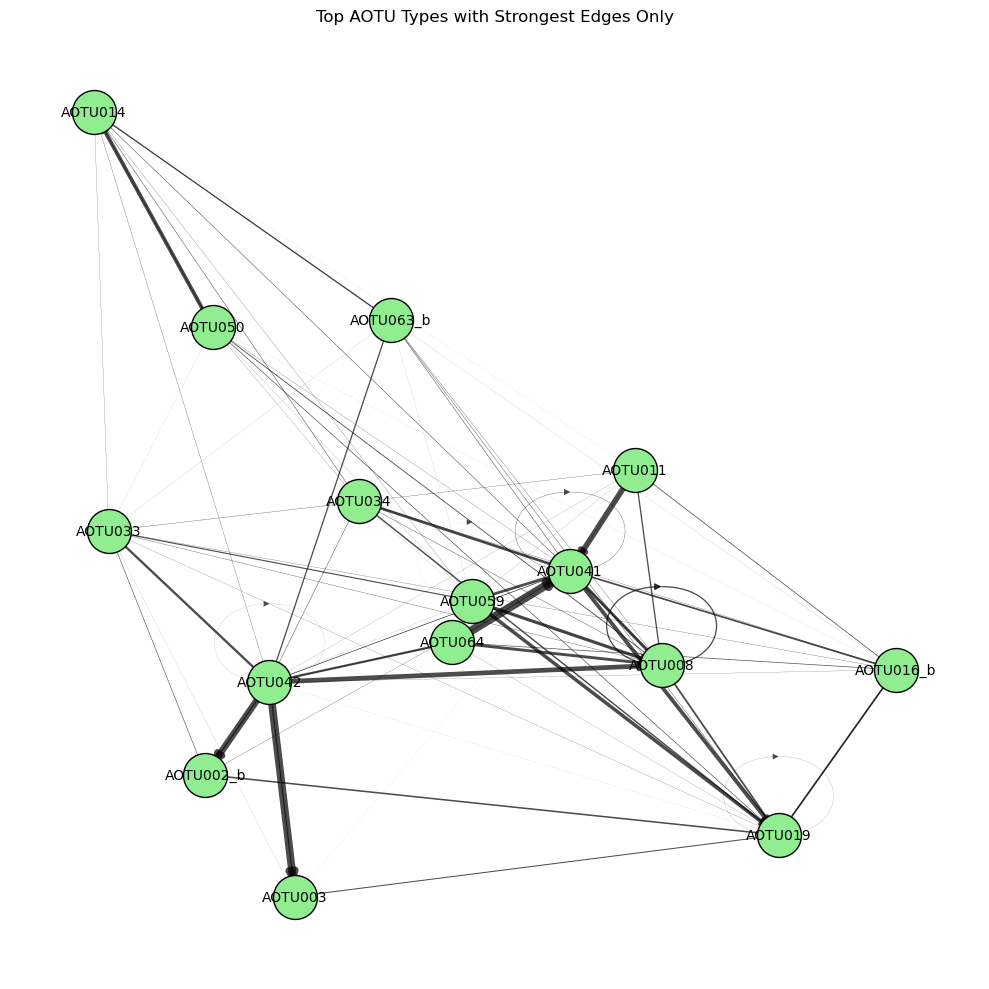

In [116]:
# Prune weak edges (optional threshold, e.g. > 10)
pruned_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 10]
H = G.edge_subgraph(pruned_edges).copy()

# Re-layout pruned graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(H, seed=1, k=1.5)

nx.draw_networkx_nodes(H, pos, node_size=1000, node_color='lightgreen', edgecolors='k')
nx.draw_networkx_labels(H, pos, font_size=10)

weights = [H[u][v]['weight'] for u, v in H.edges()]
scaled_weights = [w / max(weights) * 6 for w in weights]

nx.draw_networkx_edges(H, pos, width=scaled_weights, arrows=True, alpha=0.7, edge_color='black')

plt.title("Top AOTU Types with Strongest Edges Only")
plt.axis('off')
plt.tight_layout()
plt.show()


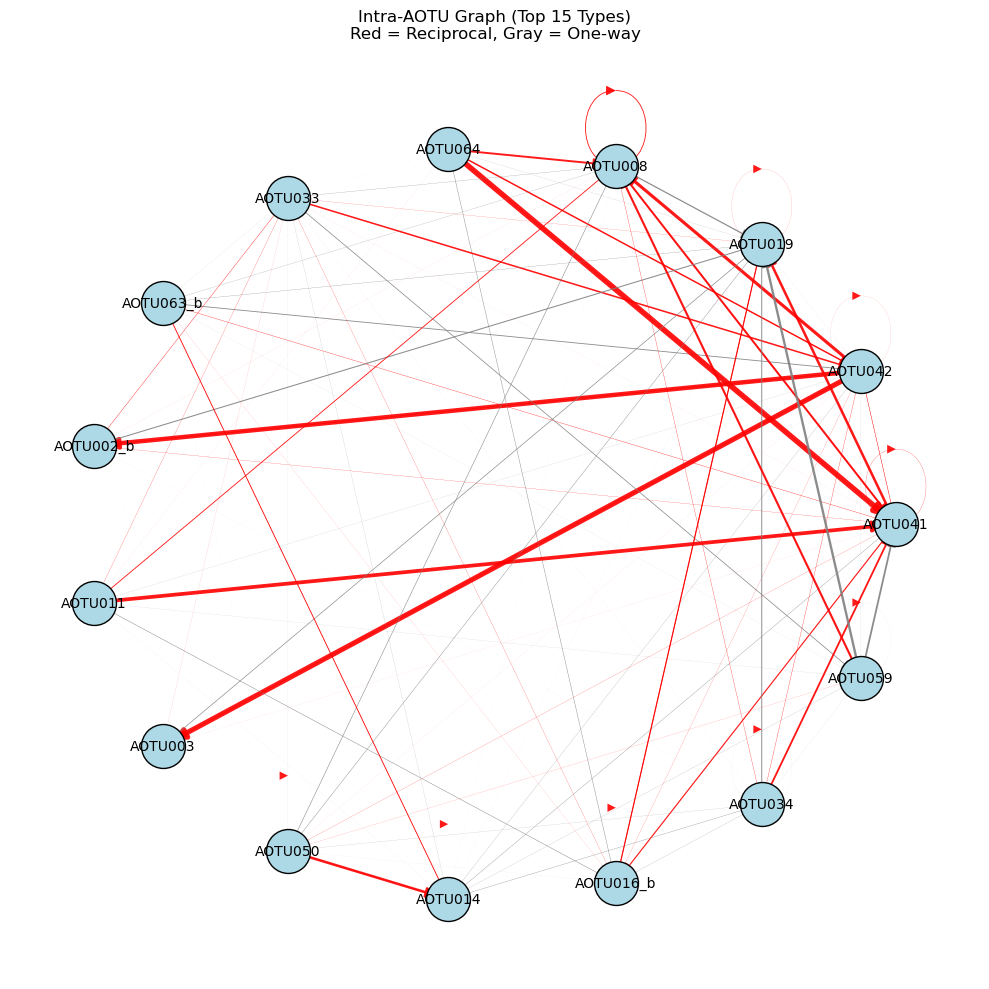

In [117]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph from top-15 intra-AOTU matrix
G = nx.DiGraph()

# Only include types in the top 15
top15_types = type_total.head(15).index.tolist()
matrix_top15 = matrix_df.loc[top15_types, top15_types]

# Add edges and weights
for pre in matrix_top15.index:
    for post in matrix_top15.columns:
        weight = matrix_top15.loc[pre, post]
        if weight > 0:
            G.add_edge(pre, post, weight=weight)

# Detect reciprocal (bidirectional) connections
reciprocal_edges = set()
for u, v in G.edges():
    if G.has_edge(v, u):
        reciprocal_edges.add((u, v))
        reciprocal_edges.add((v, u))

# Edge styling: red for reciprocals, gray for one-way
edge_colors = ['red' if (u, v) in reciprocal_edges else 'gray' for u, v in G.edges()]

# Scale edge widths by weight
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_w = max(edge_weights)
edge_widths = [w / max_w * 4 for w in edge_weights]

# Draw graph
plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue', edgecolors='k')
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    arrowstyle='-|>',
    arrowsize=15,
    alpha=0.9
)

plt.title("Intra-AOTU Graph (Top 15 Types)\nRed = Reciprocal, Gray = One-way")
plt.axis('off')
plt.tight_layout()
plt.show()


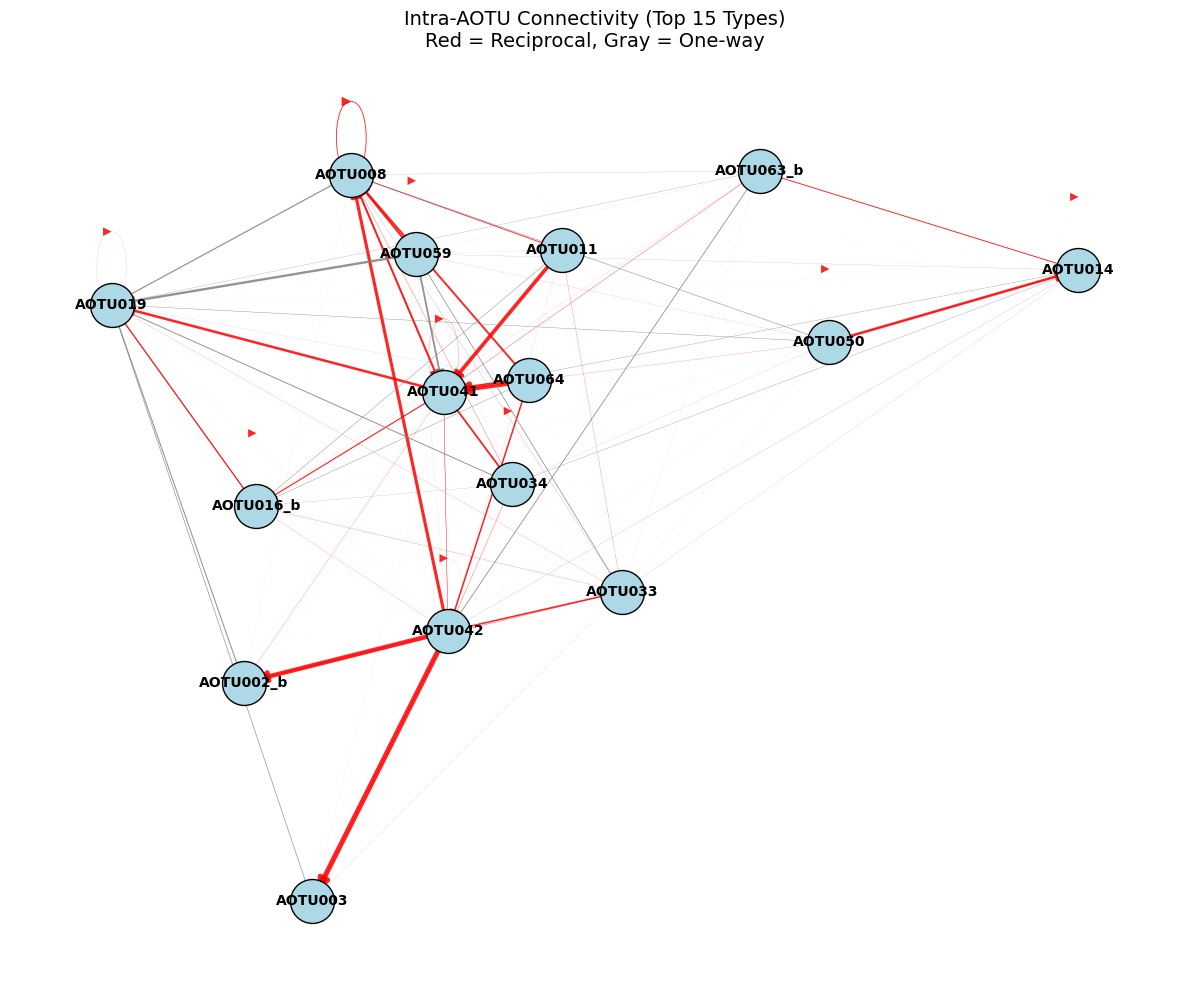

In [118]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph from top-15 intra-AOTU matrix
G = nx.DiGraph()

top15_types = type_total.head(15).index.tolist()
matrix_top15 = matrix_df.loc[top15_types, top15_types]

# Add weighted edges
for pre in matrix_top15.index:
    for post in matrix_top15.columns:
        weight = matrix_top15.loc[pre, post]
        if weight > 0:
            G.add_edge(pre, post, weight=weight)

# Identify reciprocal (bidirectional) connections
reciprocal_edges = set()
for u, v in G.edges():
    if G.has_edge(v, u):
        reciprocal_edges.add((u, v))
        reciprocal_edges.add((v, u))

# Set edge color: red if reciprocal, gray if one-way
edge_colors = ['red' if (u, v) in reciprocal_edges else 'gray' for u, v in G.edges()]

# Set edge widths scaled by weight
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_w = max(edge_weights)
edge_widths = [w / max_w * 4 for w in edge_weights]

# Use force-directed layout
pos = nx.spring_layout(G, seed=42, k=1.2)  # k controls spacing

# Plot graph
plt.figure(figsize=(12, 10))

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    arrowstyle='-|>',
    arrowsize=15,
    alpha=0.85
)

plt.title("Intra-AOTU Connectivity (Top 15 Types)\nRed = Reciprocal, Gray = One-way", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


### Male specific AOTUs

/var/folders/nz/36wz0cz90t34jt3ryz6_n08w0000gp/T/ipykernel_74590/2911603272.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=top_inputs, x='weight', y='type_pre', palette='Blues_r')


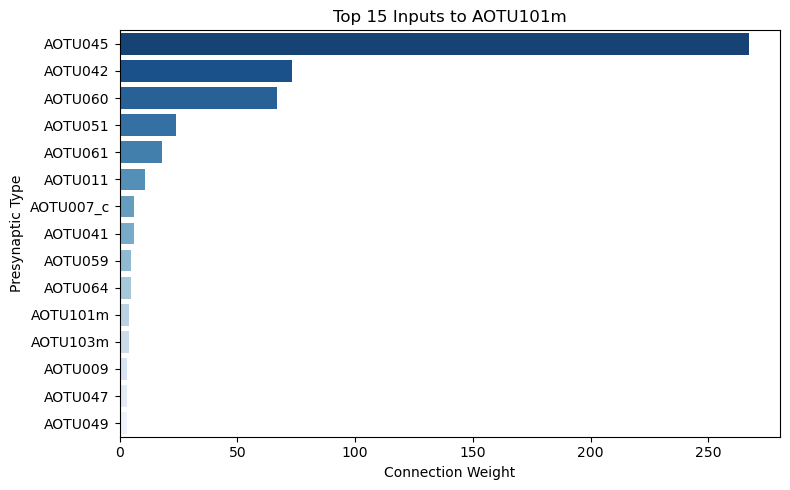

In [124]:


# Get connections where AOTU101m is the postsynaptic type
inputs_to_AOTU101m = conn_AOTU_df_type[conn_AOTU_df_type['type_post'] == 'AOTU101m']

# Sort and take top 15
top_inputs = inputs_to_AOTU101m.sort_values(by='weight', ascending=False).head(15)

# Plot
plt.figure(figsize=(8, 5))
sb.barplot(data=top_inputs, x='weight', y='type_pre', palette='Blues_r')
plt.title('Top 15 Inputs to AOTU101m')
plt.xlabel('Connection Weight')
plt.ylabel('Presynaptic Type')
plt.tight_layout()
plt.show()





/var/folders/nz/36wz0cz90t34jt3ryz6_n08w0000gp/T/ipykernel_74590/3051653666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=top_outputs, x='weight', y='type_post', palette='Greens_r')


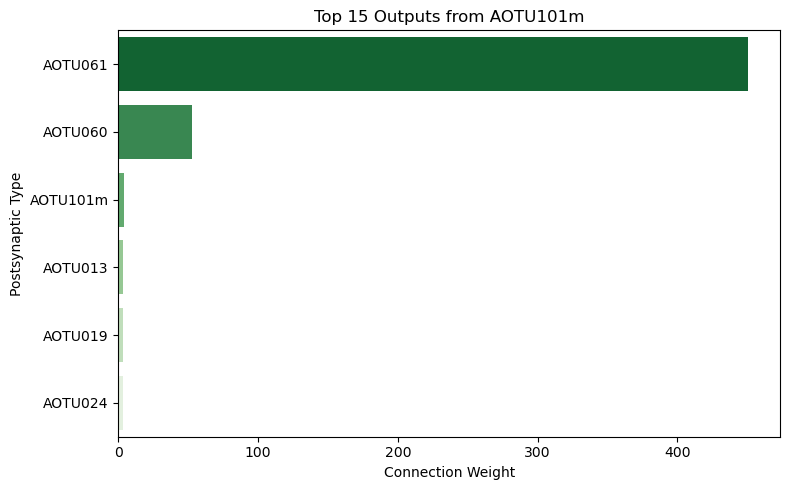

In [125]:
# Get connections where AOTU101m is the presynaptic type
outputs_from_AOTU101m = conn_AOTU_df_type[conn_AOTU_df_type['type_pre'] == 'AOTU101m']

# Sort and take top 15
top_outputs = outputs_from_AOTU101m.sort_values(by='weight', ascending=False).head(15)

# Plot
plt.figure(figsize=(8, 5))
sb.barplot(data=top_outputs, x='weight', y='type_post', palette='Greens_r')
plt.title('Top 15 Outputs from AOTU101m')
plt.xlabel('Connection Weight')
plt.ylabel('Postsynaptic Type')
plt.tight_layout()
plt.show()


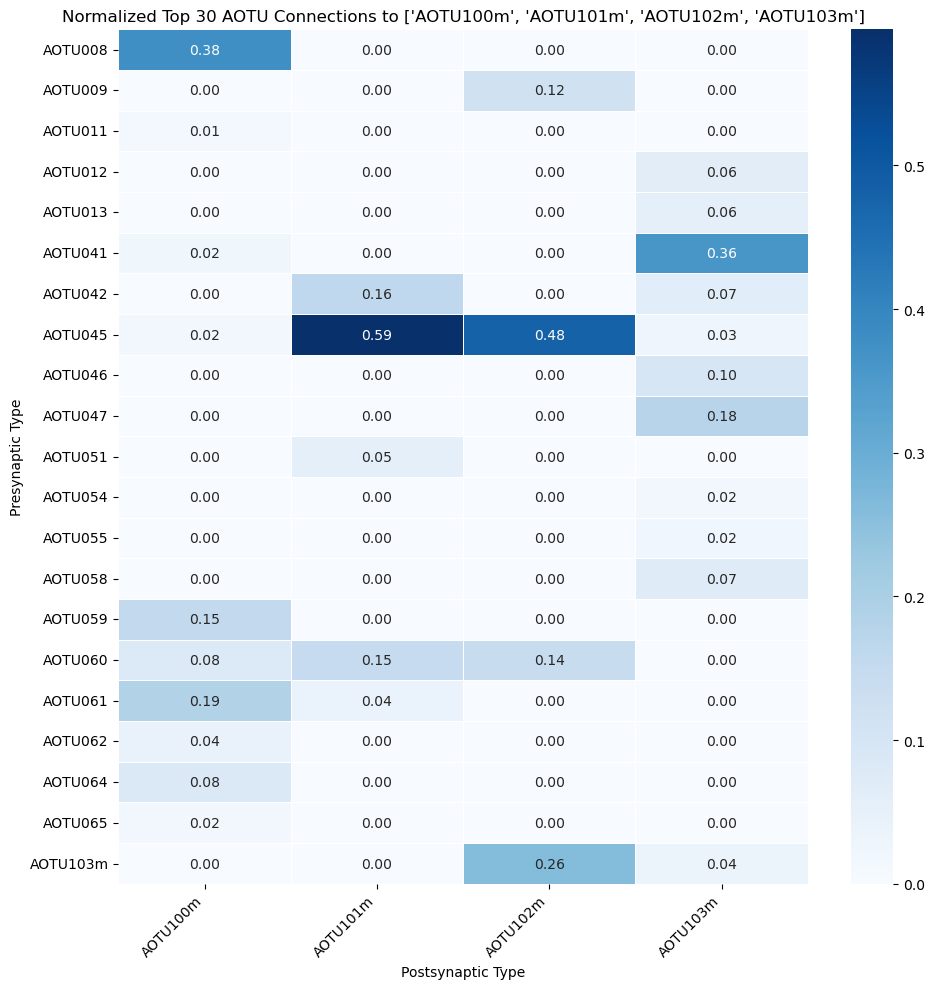

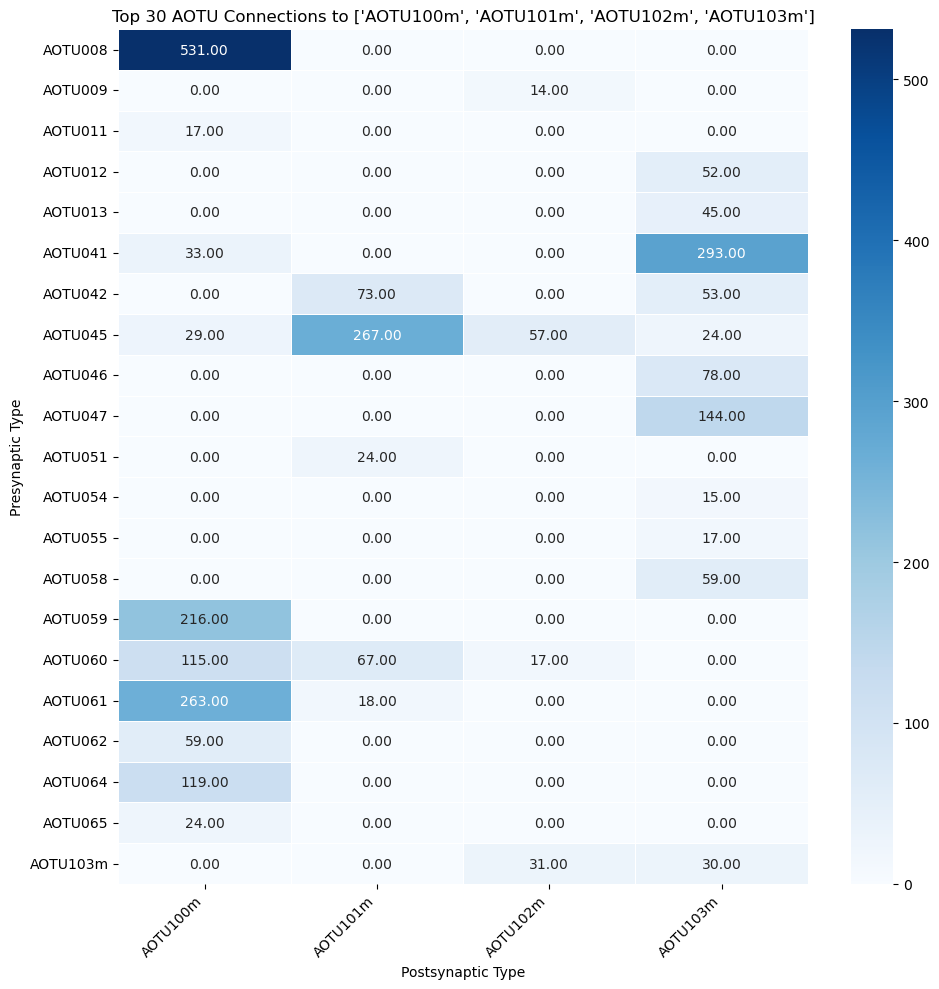

In [78]:
target_types = ['AOTU100m', 'AOTU101m', 'AOTU102m', 'AOTU103m']
# Filter only connections into the 4 target types
filtered_df = conn_AOTU_df_type[conn_AOTU_df_type['type_post'].isin(target_types)]
# Sort by connection weight and take top 30 connections
top30_conn = filtered_df.sort_values(by='weight', ascending=False).head(30)

# Row labels will be type_pre + '→' + type_post for clarity
top30_conn['pair'] = top30_conn['type_pre'] 
# Pivot to matrix format: rows = connection pair, columns = the 4 target types
matrix_top30 = top30_conn.pivot_table(index='pair', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Normalize each column so it sums to 1
norm_matrix_top30 = matrix_top30.div(matrix_top30.sum(axis=0), axis=1)

plt.figure(figsize=(10, 10))
ax = sb.heatmap(norm_matrix_top30, cmap='Blues', annot=True, fmt=".2f", linewidths=0.5)

ax.set_title("Normalized Top 30 AOTU Connections to ['AOTU100m', 'AOTU101m', 'AOTU102m', 'AOTU103m']")
ax.set_xlabel('Postsynaptic Type')
ax.set_ylabel('Presynaptic Type')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



#Plot not normalized 

plt.figure(figsize=(10, 10))
ax = sb.heatmap(matrix_top30, cmap='Blues', annot=True, fmt=".2f", linewidths=0.5)

ax.set_title("Top 30 AOTU Connections to ['AOTU100m', 'AOTU101m', 'AOTU102m', 'AOTU103m']")
ax.set_xlabel('Postsynaptic Type')
ax.set_ylabel('Presynaptic Type')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




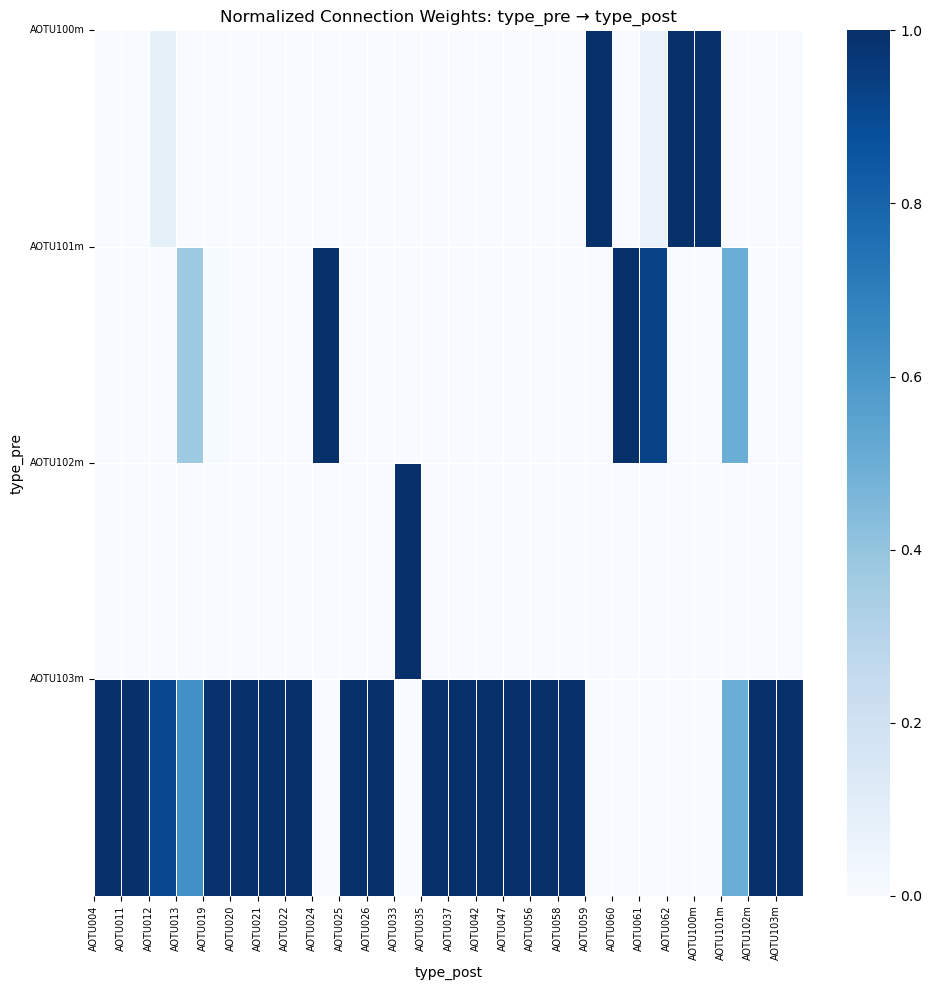

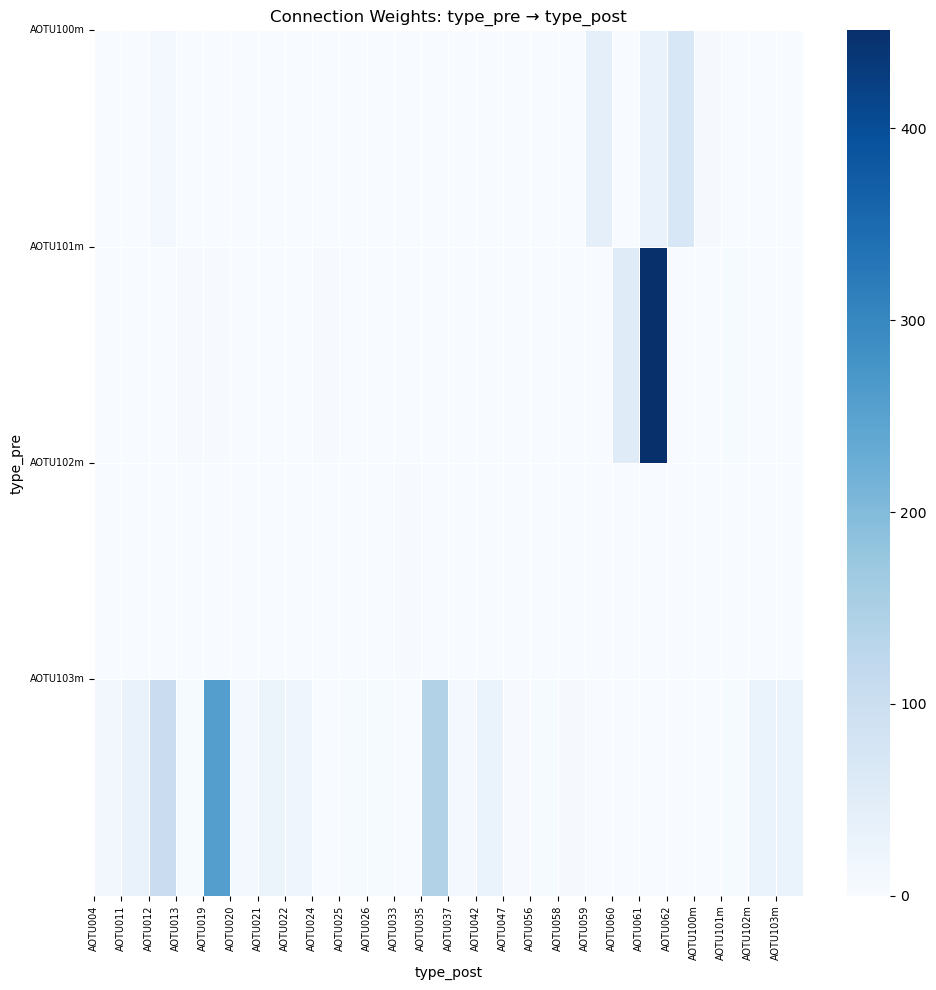

In [80]:
#  Define pre- and post-synaptic cell types
celltypes_pre = ['AOTU100m', 'AOTU101m', 'AOTU102m', 'AOTU103m']
celltypes_post = AOTU_celltypes
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_AOTUm_df = merge_neuron_properties(neu_df, conn_df)


# Group by type combinations and sum the weights
conn_AOTUm_df_type = conn_AOTUm_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()
conn_AOTUm_df_type


# Pivot to create matrix form of the connection weights
matrix_df = conn_AOTUm_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)

conn_AOTUm_df_type_sort = conn_AOTUm_df_type.sort_values(by='weight', ascending=False)

#filter for only strong connections
conn_AOTUm_df_type_top = conn_AOTUm_df_type_sort[conn_AOTUm_df_type_sort['weight']>300]


# Create the heatmap
plt.figure(figsize=(10, 10))
ax = sb.heatmap(norm_matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Normalized Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()


# Not Normlized Create the heatmap
plt.figure(figsize=(10, 10))
ax = sb.heatmap(matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(matrix_df.index)))
ax.set_yticklabels(matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(matrix_df.columns)))
ax.set_xticklabels(matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()


